In [165]:
from matplotlib import pyplot as plt
import sys

import tensorflow as tf

In [148]:
t1 = plt.imread("./tt1.png")
t2 = plt.imread("./tt2.png")
t3 = plt.imread("./tt3.png")
t4 = plt.imread("./tt4.png")
t5 = plt.imread("./tt5.png")

In [202]:
row = t1.ravel().shape[0]

tf.reset_default_graph()
g = tf.get_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=[None, row])
Y = tf.placeholder(dtype=tf.float32, shape=[None, row])

W1 = tf.Variable(tf.truncated_normal(shape=[row, 4]))
L1 = tf.sigmoid(tf.matmul(X, W1))

W2 = tf.Variable(tf.truncated_normal(shape=[4, row]))
output = tf.sigmoid(tf.matmul(L1, W2))

loss = tf.losses.sigmoid_cross_entropy(Y, output)
learn = tf.train.AdamOptimizer().minimize(loss)

initializer = tf.global_variables_initializer()

In [203]:
feed_dict1 = {
    X: [t1.ravel(), t2.ravel(), t3.ravel(), t4.ravel()],
    Y: [t2.ravel(), t3.ravel(), t4.ravel(), t5.ravel()]
}

feed_dict2 = {
    X: [t1.ravel()],
    Y: [t2.ravel()]
}

In [221]:
sess = tf.Session(graph=g)
sess.run(initializer)

for i in range(10000):
    v, _ = sess.run([loss, learn], feed_dict=feed_dict1)
    sys.stdout.write("\r% 5d | %0.9f"%(i, v))

 9999 | 0.356567979

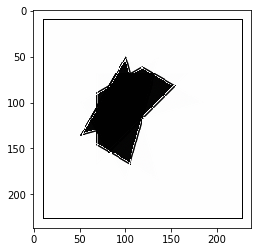

In [222]:
answer = sess.run(output, feed_dict={X: [t1.ravel()]})
plt.imshow(answer.reshape(t1.shape))
plt.show() 

In [232]:
class Plotter():

    def __init__(self, A):
        self._initialize(A)
        
    def _initialize(self, A):
        self.A = A
        self.normalize()
        
    def add_plot(self, A):
        
        for A_ in A:
            self.A.append(A_)
        self.normalize()
        
        return self
            
    def normalize(self):
        
        A = self.A
        
        a = np.concatenate(A).T.ravel()
        x, y = a[:len(a)//2], a[len(a)//2:]
        xc, yc = max(x)-min(x), max(y)-min(y)
        c = max(xc, yc)
        self.c = c
        
        self.A = [(A_-[min(x)+xc/2, min(y)+yc/2])/c
                  for A_ in A]
        
        return self

    def rotate(self, ro):
        
        sin, cos = np.sin, np.cos
        angle = np.pi/180*ro
        
        ro_mat = np.array(
            [cos(angle), -sin(angle), sin(angle), cos(angle)]
        ).reshape(2, 2)
        
        self.A = [A_.dot(ro_mat) for A_ in self.A]
        
        return self
        
    def move(self, direction):
        self.A = [A_+direction for A_ in self.A]
        return self
        
    def resize(self, size):
        self.A = [A_*size for A_ in self.A]
        return self
        
    def shake(self, resol=60, window=10, ratio=0.006):

        def _get_line(p1, p2):
            direction = p2-p1
            resol_ = int(resol*np.linalg.norm(direction))
            line = np.linspace(0, 1, resol_)
            return [p1+direction*v for v in line][:-1]

        def shake_A(A_):
            lines = [
                _get_line(A_[i], A_[i+1])
                for i in range(len(A_)-1)
            ]
            line = np.concatenate(lines)
            noise = np.random.randn(*line.shape)
            ma_noise = pd.Series(noise.ravel()).rolling(window).mean()
            noise = np.array(ma_noise.fillna(0)).reshape(noise.shape)
            return np.concatenate([line+noise*ratio, A_[-1:]])
        
        A = self.A
        self.A = [shake_A(A_) for A_ in A if len(A_) > 1]
        return self

    def draw(self, margin=0.1):
        
        plt.figure(figsize=[3, 3])
        
        p = plt.axes([0, 0, 1, 1])
        for A_ in self.A:
            A_ = A_.T
            p.plot(A_[0], A_[1], c="black")
        p.get_xaxis().set_visible(False)
        p.get_yaxis().set_visible(False)
        axis = np.array([-0.5, 0.5, -0.5, 0.5])*(1+margin)
        p.axis(axis)
            
        plt.show()

In [319]:
datas = []
for i in range(0, 180, 30):
    p = Plotter([np.array([[0, 0], [0, 1], [1, 0], [0, 0]])]).rotate(i).resize(0.5)
    datas.append(p.A[0])
datas = np.array(datas)

In [324]:
tf.reset_default_graph()
g = tf.get_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=[4, 2])
Y = tf.placeholder(dtype=tf.float32, shape=[4, 2])

W = tf.Variable(tf.truncated_normal(shape=[2, 2]))
output = tf.matmul(X, W)

loss = tf.losses.mean_squared_error(Y, output)
learn = tf.train.AdamOptimizer().minimize(loss)

initializer = tf.global_variables_initializer()

In [325]:
sess = tf.Session(graph=g)
sess.run(initializer)

for i in range(10000):
    v, _ = sess.run([loss, learn], feed_dict={X: datas[0], Y: datas[1]})
    sys.stdout.write("\r% 5d | %0.9f"%(i, v))

 9999 | 0.000000000

In [328]:
sess.run(W)

array([[ 0.86602527, -0.50000024],
       [ 0.50000024,  0.86602515]], dtype=float32)

In [329]:
sin, cos = np.sin, np.cos
angle = np.pi/180*30
np.array(
    [cos(angle), -sin(angle), sin(angle), cos(angle)]
).reshape(2, 2)

array([[ 0.8660254, -0.5      ],
       [ 0.5      ,  0.8660254]])

### 패턴 변화를 학습 가능한 아키텍쳐

1. 정말 정형화된 변환. 예를들어. 축이 고정된 아핀변환

> 사실 다음 순번과의 차이만 학습하는 것으로 학습이 가능하다.

> 아핀변환의 변환행렬을 신경망으로 유추하는건 지레 짐작해도 알 수 있다.

2. 좀더 응용해서, 축이 뒤바뀌는 변환이라면

> 사실 이건 고정된 도형 생성 공식에 의해 만들어진 것이라, 파라미터 압축이 가능

> 파라미터를 압축하고자 한다면 접근법은, 생성모델일 수 밖에 없는데.. 무엇을 쓸까.

3. 좀더 응용해서, 객체가 변한다면

> 위와 동일한 논리 전개가 가능

4. 더 응용해서, 객체가 랜덤이라면.

> 객체가 무엇인지 알 필요 없이 로컬리제이션을 해야하는가?

> 굳이 신경망을 써야하는가? openCV를 이용하면 객체가 몇개인지 알 수 있지 않은가

5. 더 응용해서, 축이 랜덤이라면.

> 위와 같은 논리 전개가 가능

6. 더 응용해서, 객체 자체가 랜덤성이 부여된다면.

> 어떡하지? 엣지디텍션? 그럼 신경망을 안쓰는건데

> 신박하려면 엣지 디텍션을 신경망으로 구현해야하나?

7. 이 생각을 일반화 시키자면

> 베이지안 모델을 근간으로 하는 신경망을 써야하나?

> 그러니까.. 어떤 프라이어를 두고 업데이트 해나가는 방식

> 모델이 학습할 수록 이부분은 랜덤일 확률을 증가시키거나 감소시켜 나가야 하는건가?

### 신경망이 포함할 수 있는 오퍼레이션의 범위

> 신경망으로 홀수와 짝수를 구분하는 알고리즘을 어떻게 만들까?

> 사실 홀짝 구분은 나머지 연산의 특이케이스니까, 신경망으로 나머지 연산을 할 수 있을까?

> 저는 1차원 공간에서 대충 홀짝의 분포는 다음과 같다.

> 이를 효과적으로 나누기 위해선 다음처럼 무한한 파동함수가 필요하다는 것을 깨달았습니다.

![](img/1.png)

> 경험적으로 생각해보았을 때 파동함수를 사칙연산으로 근사하기 위해서 테일러 근사를 하는데

> 무한한 영역에 파동함수를 테일러근사 하는 것은 무한개의 파라미터가 필요하다.

> 또한 식을 보면, 어떠한 수렴의 형태로 표현할 수 없다. 즉, 식의 뒷부분이 수치해석적으로 생략 불가능하다.

![](img/2.png)

> 파동함수는 일반 신경망으로는 근사할수 없을것이다.

> 이 문제는 일반신경망으로는 풀수 없고 RNN으로 접근해야 할 것이다.

> "RNN이 시퀀스에 대한 파동함수 역할을 한다."

> "그럼 굳이 RNN으로 풀 필요가 없이 활성함수를 sin함수로 바꾸면 되는게 아닌가"

### 막간 아이디어

> 일반 신경망에서 활성함수만을 변경해 RNN과 동일한 신경망을 만들 수 있을 수도 있겠다.

> {시드모이드, 렐루, ...} => {sin, cos, ...}

> 이 문제는 신경망의 활성함수를 파동함수를 쓴다면 쉽게 일반 신경망으로도 풀리게 됩니다.

> https://openreview.net/pdf?id=Sks3zF9eg
![](img/3.png)



### 데이터와 파라미터 개수

> Simbol (1, 1, 1) => (2, 4, 3) => (3, 6, 9)의 규칙으로 만들어낸 100 by 100 이미지 세장이 있다면

> 3만차원이 3차원으로 줄여지는 것이 이상적이다.

### 번외

![](img/11.png)

> 그냥 오토인코더 히든 레이어 1개짜리 데이터 한개짜리로 심심해서 해봤는데..

> 어떤 로스를 이용하든 색상이 역전되어서 나옴.. 재밋어서 올려봄..

### 비정형

> end to end 로 언더스코어를 치고

> 어텐션 기준으로 잘라나가면서 어그맨테이션을 하면 더 낫지 않으려나..

> 극한의 어그맨테이션을 향하여..

> 명준이의 지적이 너무 맞는말이라.. 이걸로는 도저히 팀플을 할 용기가 안난다.

> 그냥 혼자해봐야겠다.. 틀려도 내가 이해할 때까지는 깨달은게 아니라서..